# CHAPTER 3

## The reasons for using attention mechanisms in neural networks



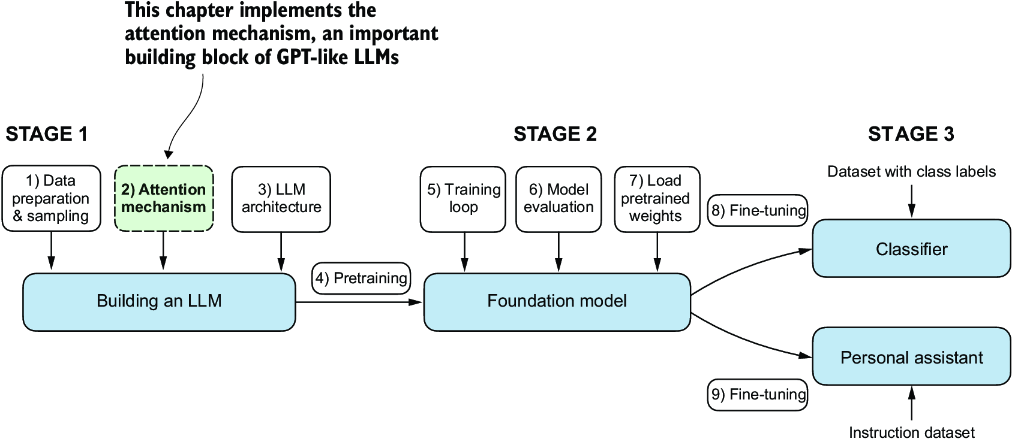


We will implement 4 different variants of attention machanism, These different attention variants build on each other. The goal is to arrive at a compact and efficient implementation fo multi-head attention that we can plug into the LLM.

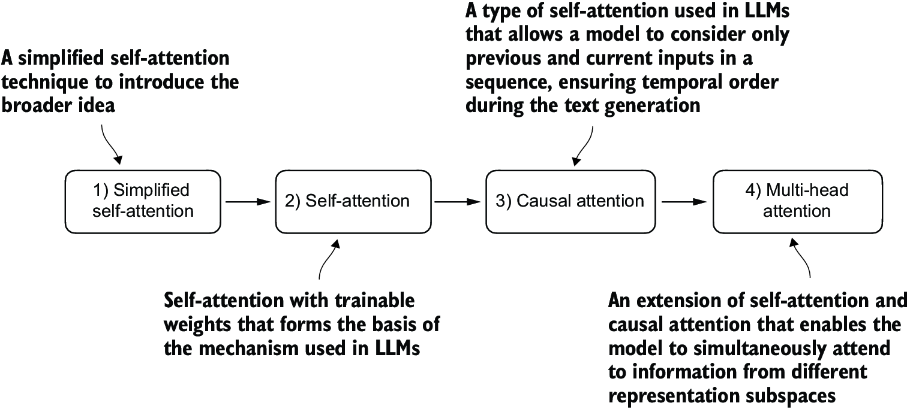

### 3.1 The problem with modeling long sequence

it’s not possible to merely translate word by word. Instead, the translation process requires contextual understanding and grammatical alignment.
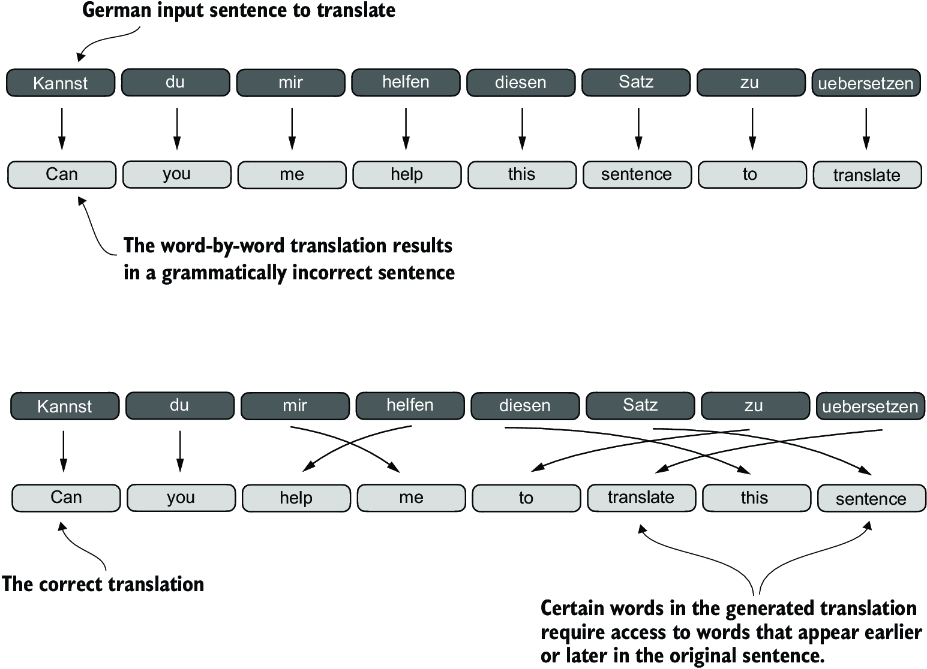

To address this problem, it is common to use a deep neural network with two submodules, an encoder and a decoder.

********

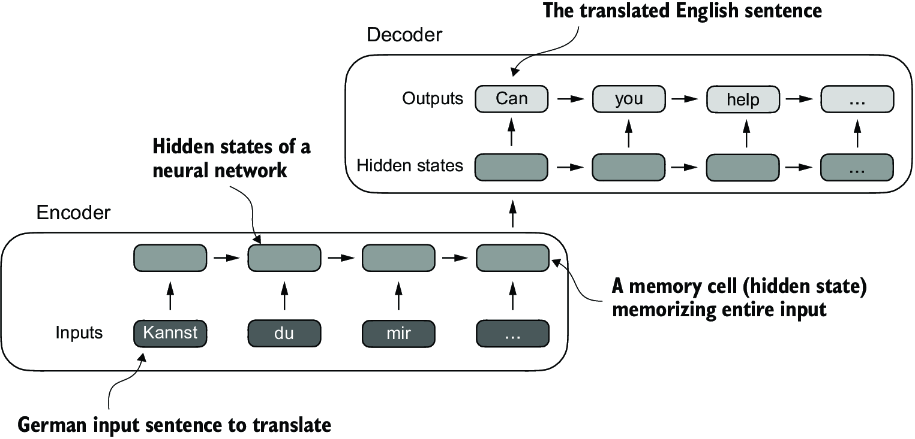

Before the advent of transformer models, encoder–decoder RNNs were a popular choice for machine translation. The encoder takes a sequence of tokens from the source language as input, where a hidden state (an intermediate neural network layer) of the encoder encodes a compressed representation of the entire input sequence. Then, the decoder uses its current hidden state to begin the translation, token by token.


**The big limitation of encoder–decoder RNNs is that the RNN can’t directly access earlier hidden states from the encoder during the decoding phase. Consequently, it relies solely on the current hidden state, which encapsulates all relevant information. This can lead to a loss of context, especially in complex sentences where dependencies might span long distances.**

### 3.2 Cpaturing data dependencies with attention mechanisms

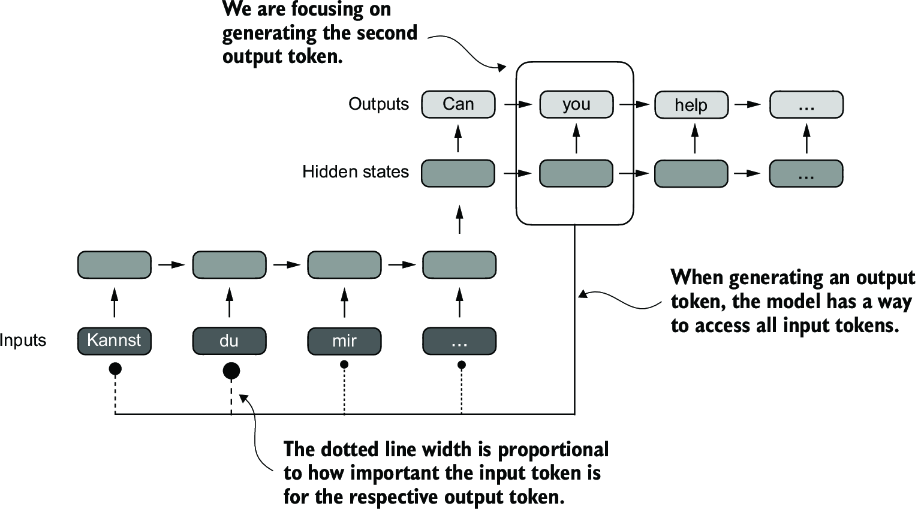
Using an attention mechanism, the text-generating decoder part of the network can access all input tokens selectively. This means that some input tokens are more important than others for generating a given output token. The importance is determined by the attention weights

only three years later, researchers found that RNN architectures are not required for building deep neural networks for natural language processing and proposed the original transformer architecture.

Self-attention is a mechanism that allows each position in the input sequence to consider the relevancy of, or “attend to,” all other positions in the same sequence when computing the representation of a sequence. Self-attention is a **key component** of contemporary LLMs based on the transformer architecture, such as the GPT series.

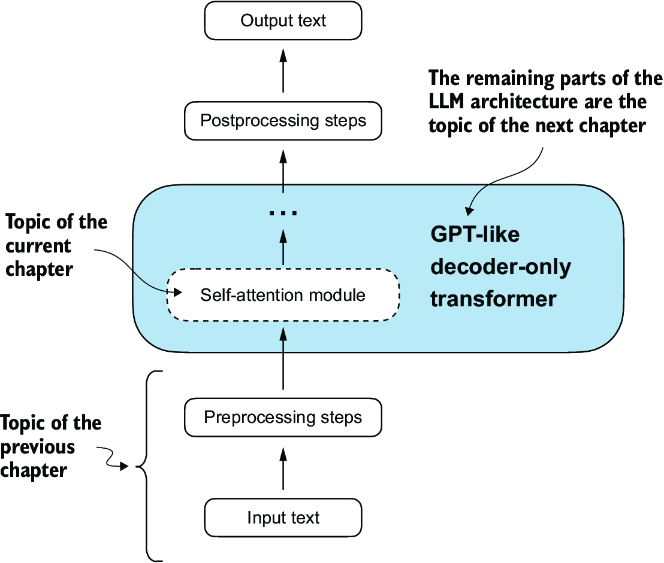

Self-attention is a mechanism in transformers used to compute more efficient input representations by allowing each position in a sequence to interact with and weight the importance of all other positions within the same sequence.

> 记住：目前我们的顺序是 文字输入 -> 加密数字形态 -> ?

### 3.3 Attending to different parts of the input with self-attention.

The *“self”* refers to the mechanism’s ability to compute attention **weights** by relating different **positions** within a single input sequence.

#### 3.3.1 A simple self-attention mechanism without trainable weights

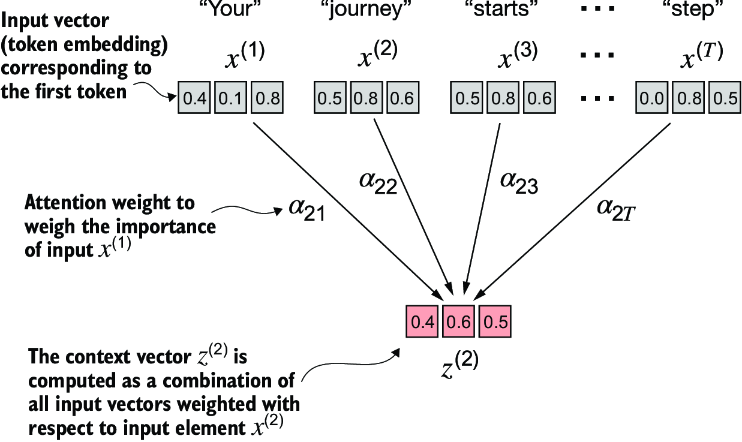

The goal of self-attention is to compute a context vector for each input element that combines information from all other input elements. In this example, we compute the context vector z(2). The importance or contribution of each input element for computing z(2) is determined by the attention weights a21 to a2T. When computing z(2), the attention weights are calculated with respect to input element x(2) and all other inputs.

> *Context vectors* play a crucial role in self-attention. Their purpose is to create enriched representations of each element in an input sequence (like a sentence) by incorporating information from all other elements in the sequence


In [67]:
import torch
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

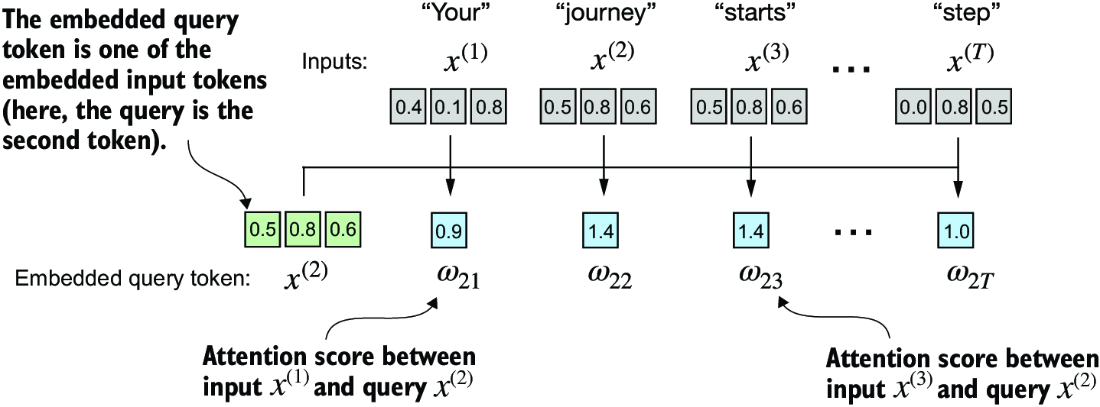

> 第一步： 在输入的Matrix中，针对每一个vector，都要算出他对应其他vector的 Attention score。重点是了解每一步所生成结果的维度是什么。【**Attention score**】-> 【Attention Weight】->【Context Vector】

> 以下的步骤是以 X2 为例. 算出x2 和所有vector的 Dot product。

* 1. The first step: Compute the intermediate values w (Attention scores)
> *Why we not use the token embedding?* <br>
> 0.87 is truncated to 0.8. In this truncated version, the embeddings of the words “journey” and “starts” may appear similar by random chance.

In [68]:
# calculate the intermediate attention scores between the query token and each input token.
# We determine these scores by computing the dot product of the query, x(2), with every other input token:

second_word_query_token = inputs[1] # the second word's token
attention_score_to_second_word = torch.empty(inputs.shape[0]) # same shape with the first dim [6] of inputs [6, 3] but with uninitialized data
for num_index, matrix in enumerate(inputs):
  attention_score_to_second_word[num_index] = torch.dot(matrix, second_word_query_token)

attention_score_to_second_word

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])

> the dot product is a measure of similarity because it quantifies ***how closely two vectors are aligned***: a higher dot product indicates a greater degree of alignment or similarity between the vectors. In the context of self-attention mechanisms, the dot product determines the extent to which each element in a sequence focuses on, or “attends to,” any other element: the higher the dot product, the higher the similarity and attention score between two elements.

> 第二步： 对所得到的值，进行 Normalize， torch.softmax(matrix, dim=-1)

* 2. The second step: Nomalize the weights. This normalization is a convvention that is useful for interpretation and maintaining training stability in an LLM.

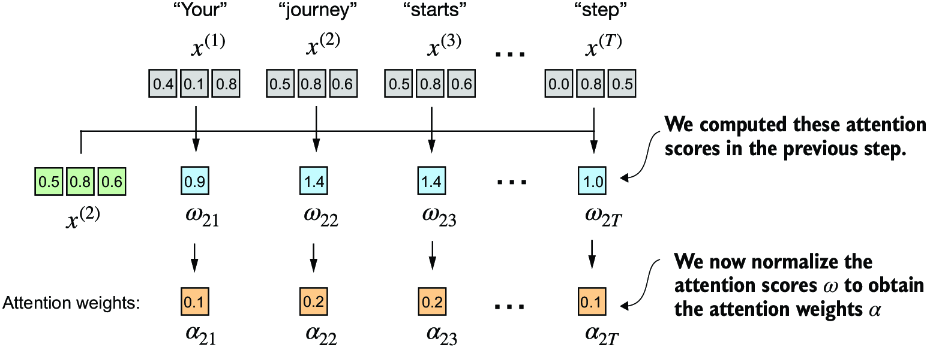

In [69]:
sum_of_weights = attention_score_to_second_word.sum()
normalize_weights = attention_score_to_second_word / sum_of_weights
normalize_weights

tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])

> In practice, It's more common and advisable to use the *Softmax* function for normalization. In addition, the Softmax function always ensure the weights are positive. This makes output interpretable as probabilities or relative importance, where higher weights indicate greater importance.

In [70]:
# Attention weights respect to input 2

normalize_fn = torch.nn.Softmax(dim=0)
# or
softmax_result = torch.softmax(attention_score_to_second_word, dim=-1)
softmax_result

tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])

> The results are bit difference.
> 1.   tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
> 2.   tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
> ***
> It becauses the Softmax takes exponation of each value.
> Softmax = exp(tensor_i) / sum (exp (tensor))
> Make difference more obviously.


第三步： 用weight 乘以每一个对应的vector，最后求和。

* 3. Calculating the context vector z(2) by **multiplying** the embedded input tokens x(i), with the corresponding weights and then **summing** the resulting vecetors.

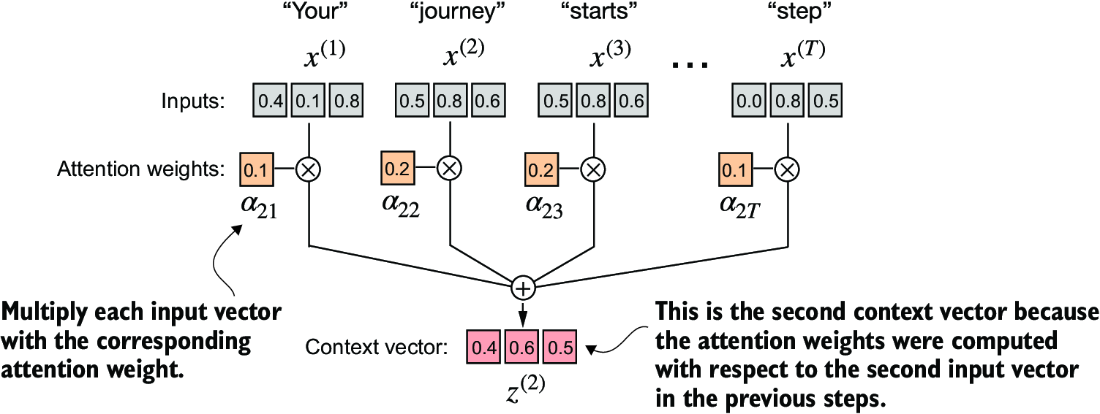

In [71]:
# Context vector for input 2
# the context vector should have same shape with the query's shape.
#从inputs encoded 变成 context vector, 目的是通过dim不变的情况下,让所有的vector之间通过weights产生连接.
query = inputs[1]

context_vector_v2 = torch.zeros(query.shape)
for idx, matrix in enumerate(inputs):
  context_vector_v2 += matrix * softmax_result[idx]

context_vector_v2

tensor([0.4419, 0.6515, 0.5683])

#### 3.3.2 Computing attention weights for all input tokens

这里我们把之前学到的，一个vector如何得到他的context vector用在所有的vector上面。

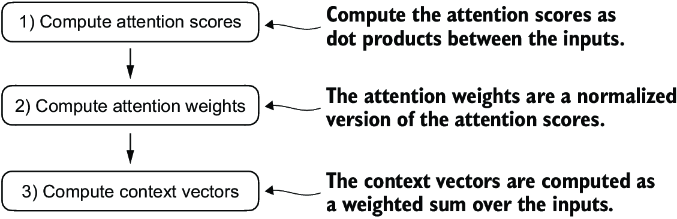

> COMPUTE ATTENTION SCORES。 简单的做法就是 matrix @ matrix.T

Step 1, Token embedding for each of them.

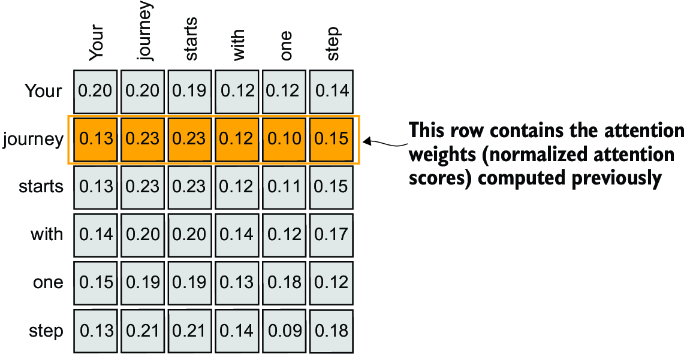

In [72]:
# Dot product for each 1-1 2-1 3-1 ...2-1 2-2 3-2...6-6

len_words = inputs.shape[0]
attention_score_matrix = torch.empty(len_words, len_words)
for row_index, row_value in enumerate(inputs):
  for col_index, cal_value in enumerate(inputs):
    attention_score_matrix[row_index, col_index] = torch.dot(row_value, cal_value)

attention_score_matrix

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])

⏬

In [73]:
# Faster process for Dot product
# matrix 乘以它自己的T
attention_score_matrix = inputs @ inputs.T
attention_score_matrix

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])

> Step 2: Normalize each row so that the values in each row sum to 1:
> 直接带入 torch.softmax 求Normalization

In [74]:
normalize_weights = torch.softmax(attention_score_matrix, dim=-1)
normalize_weights

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])

> Step 3: Use attention weights to compute all context vectors.
> 用 weights 的martix 乘以 原始输入matrix

In [75]:
all_context_vectors = normalize_weights @ inputs
all_context_vectors

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])

1. 如果你想用 每一个vector都乘一遍,用A@AT. 比如 当你需要计算 attention score , 你需要每一个vector都要计算一遍.
2. 如果你要用weight 关联 matrix A,就用 weight @ A, 结果是关联后的A

> 这里，我们不得不思考，为什么要进行一次求weight呢？ 在我的理解，weight就好像是关节，weight在枝干上存在越多，是不是就意味着这根枝干就越灵活呢？什么情况是太多的Weight，什么情况是太少的Weight？希望之后的学习可以找到答案。
> 这里的weight是没有training能力的。

### 3.4 Implementing self-attention with trainable weights

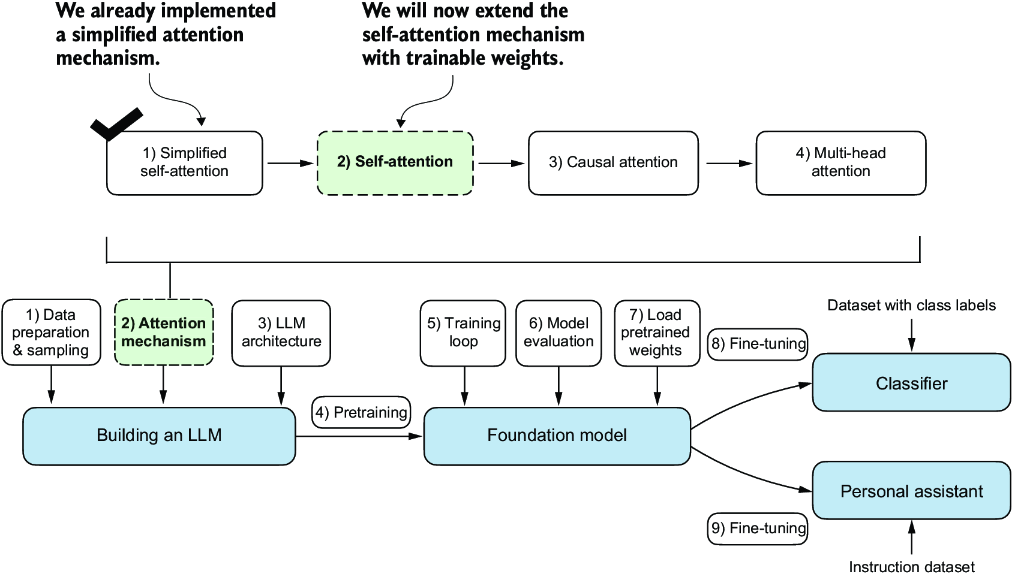

#### 3.4.1 Computing the attention weights step by step

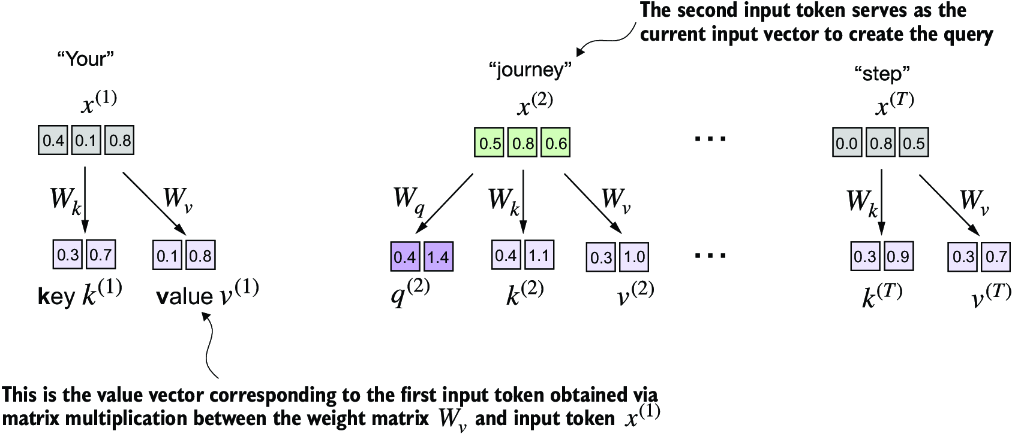

> 我觉得这里还是相对比较清晰，但是如果结合之前的内容，有时候会混淆。
> 我们要知道，上一章，我们学的是最基础的Self-attention，它本身是没有学习能力的。但是为什么呢？我的理解是，vectors之间的联系不够紧密，或者说联系过于简单。就比如过于简单的蛋白质虽然可以构成人类，但是本身是无法学习的。

In [76]:
inputs

tensor([[0.4300, 0.1500, 0.8900],
        [0.5500, 0.8700, 0.6600],
        [0.5700, 0.8500, 0.6400],
        [0.2200, 0.5800, 0.3300],
        [0.7700, 0.2500, 0.1000],
        [0.0500, 0.8000, 0.5500]])

Trainable weight matrices: Wq, Wk, and Wv.
> In the first step of the self-attention mechanism with trainable weight matrices, we compute query (q), key (k), and value (v) vectors for input elements x. Similar to previous sections, we designate the second input, x(2), as the query input. The query vector q(2) is obtained via matrix multiplication between the input x(2) and the weight matrix Wq. Similarly, we obtain the key and value vectors via matrix multiplication involving the weight matrices Wk and Wv.

Example, We start by computing only one context vector, z2, for illustration purposes. Just like the image.

*Step - 1*

In [77]:
'''
the input and output dimensions are usually the same,
but to better follow the computation, we’ll use different。
'''
x_2 = inputs[1]
dim_in = inputs.shape[1]
dim_out = 2

'''
Initialize Wq, Wk, Wv

We set requires_grad=False to reduce clutter in the outputs,
but if we were to use the weight matrices for model training,
we would set requires_grad=True to update these matrices during model training.
'''
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(dim_in, dim_out), requires_grad=False)
W_key = torch.nn.Parameter(torch.rand(dim_in, dim_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(dim_in, dim_out), requires_grad=False)

'''
Compute the query, key and value vectors, as showing in the image.
'''
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value

key_2, W_query.shape


(tensor([0.4433, 1.1419]), torch.Size([3, 2]))

> 到目前，只要跟着图示，应该可以做出来3个值。值得注意的是，matrix的维度一定要搞清楚。比如 dim_in是inputs 6*3 的 3. 这是基于Calculus中，两个Matrix相乘的条件。

> **`Weight parameters vs. attention weights`**
weight parameters are the fundamental, learned coefficients that define the network’s connections, while attention weights are dynamic, context-specific values.


* Weight Parameters = model’s permanent knowledge
* Attention Weights = model’s temporary focus on a specific input



> inputs => 6 * 3, W => 3 * 2 可得到 6 * 2的新matrix

In [78]:
keys = inputs @ W_key
values = inputs @ W_value

keys, values

(tensor([[0.3669, 0.7646],
         [0.4433, 1.1419],
         [0.4361, 1.1156],
         [0.2408, 0.6706],
         [0.1827, 0.3292],
         [0.3275, 0.9642]]),
 tensor([[0.1855, 0.8812],
         [0.3951, 1.0037],
         [0.3879, 0.9831],
         [0.2393, 0.5493],
         [0.1492, 0.3346],
         [0.3221, 0.7863]]))

*Step - 2*

Computing the attention scores.
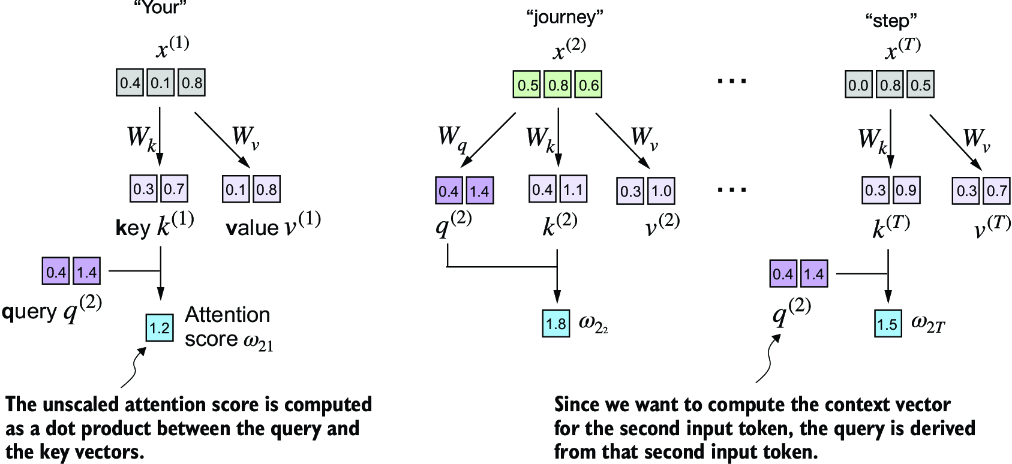

In [79]:
'''
Attention score for x2
'''
w2 = query_2.dot(key_2)

'''
Generalize this computation to all attention scores via matrix mulitiplication:
对我来说,困难的是如何快速理解 什么时候使用 @ 和 T
虽然我了解 1*3 @ 3*6 = 1*6
'''
attention_score_2 = query_2 @ keys.T
attention_score_2

'''
Go from attention scores to the attention Weights.
Scale the attention scores by dividing them by the square root of the embedding dimension of the keys
'''
d_k = keys.shape[-1] # 2
attention_weights_2 = torch.softmax(attention_score_2 / d_k ** 0.5, dim = -1)
w2, attention_score_2, attention_weights_2

(tensor(1.8524),
 tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440]),
 tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820]))

Weights:
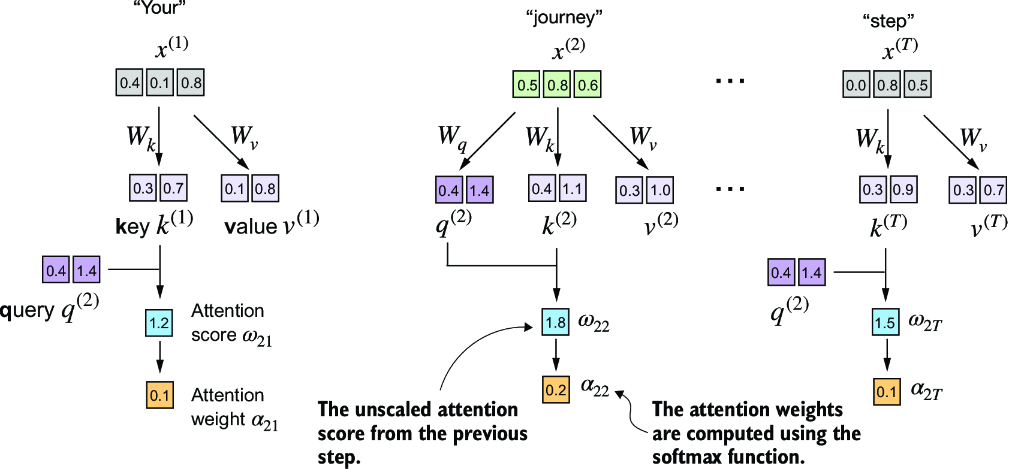

**The rationale behind scaled-dot product attention** <br>
The reason for the normalization by the embedding dimension size is to improve the training performance by avoiding small gradients. For instance, when scaling up the embedding dimension, which is typically greater than 1,000 for GPT-like LLMs, large dot products can result in very small gradients during backpropagation due to the softmax function applied to them. As dot products increase, the softmax function behaves more like a step function, resulting in gradients nearing zero. These small gradients can drastically slow down learning or cause training to stagnate.

The scaling by the square root of the embedding dimension is the reason why this self-attention mechanism is also called scaled-dot product attention.


为什么要用 scaled-dot product attention?

为了避免过小的变值, 我的理解是因为要用到gradient,比如backpropagation *通过结果的标注来改变已经赋予的Weight的值* 如果过小的Gradient, 会非常慢,但是如果过大,同样会导致找不到最低点.参考Step function.
为什么会发生:
1. dot product的值越大,代表两个vector之间的关系越紧密. 同样,和其他的vector的数值会变小. 当数值过大,或者关系非常紧密的时候,会出现gradient消失或者几乎消失. 例子 GPT-like的LLM会有上千的dimension.
2. 用sqr 来处理 Normalization的话,可以维持稳定.

*Final step*

Compute the context vectors.

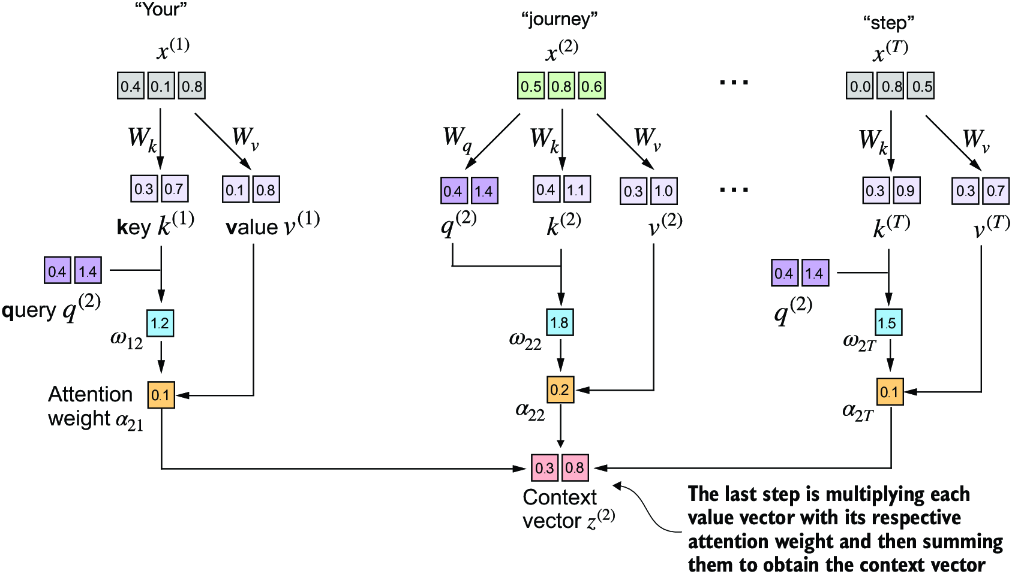

In [80]:
context_vector = attention_weights_2 @ values
context_vector, attention_weights_2.shape, values.shape

(tensor([0.3061, 0.8210]), torch.Size([6]), torch.Size([6, 2]))

>REMEMBER THIS IS ONLY FOR A SINGLE CONTEXT VECTOR z_2

****
**🔰 Why Query, Key and Value?**
>The terms “key,” “query,” and “value” in the context of attention mechanisms are borrowed from the domain of information retrieval and databases, where similar concepts are used to store, search, and retrieve information.
- A query is analogous to a search query in a database. It represents the current item (e.g., a word or token in a sentence) the model focuses on or tries to understand. The query is used to probe the other parts of the input sequence to determine how much attention to pay to them.
- The key is like a database key used for indexing and searching. In the attention mechanism, each item in the input sequence (e.g., each word in a sentence) has an associated key. These keys are used to match the query.
- The value in this context is similar to the value in a key-value pair in a database. It represents the actual content or representation of the input items. Once the model determines which keys (and thus which parts of the input) are most relevant to the query (the current focus item), it retrieves the corresponding values.
****

query: 代表"现在". 模型focuse在这个点上. 一切进一步动作都基于这个点.

Key: 就是index, 每一个点,都应该有自己的index从而找到对应的query.

Value: 值,这里的值,是指 在模型找到了那些keys最能和query相关,就这个生成对应的值. 表示每个词的实际内容或含义向量

**“给定一个查询（Query），我们根据一组键（Keys）进行匹配，找到相关的值（Values）。”**


句子：

“The cat sat on the mat.”

我们要处理其中的一个词，比如 "sat"。

步骤：
Query 是 "sat" 的表示（想知道它该关注什么）

Keys 是句子中每个词（包括它自己）的“表示”特征（用于比较）

对每个 Key，计算它和 Query 的“相似度” → 得到权重（attention scores）

用这些权重对每个 Value 加权平均 → 得到最终的输出向量（融合了上下文信息）



####3.4.2 Implementing a compact self-attention Python class


In [81]:
import torch.nn as nn
class SelfAttention_v1(nn.Module):
  def __init__(self, dim_in, dim_out) -> None:
    super().__init__()
    self.W_query = nn.Parameter(torch.rand(dim_in, dim_out))
    self.W_key = nn.Parameter(torch.rand(dim_in, dim_out))
    self.W_value = nn.Parameter(torch.rand(dim_in, dim_out))

  def forward(self, query_focus):
    keys = query_focus @ self.W_key
    queries = query_focus @ self.W_query
    values = query_focus @ self.W_value
    attention_scores = queries @ keys.T
    attention_weights = torch.softmax(attention_scores / keys.shape[-1] ** 0.5, dim = -1)
    context_vec = attention_weights @ values
    return context_vec

'''
Let's check
'''
dim_in, dim_out
torch.manual_seed(123)
v1_module = SelfAttention_v1(dim_in, dim_out)
v1_module(inputs)

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)

**OVER VIEW:**
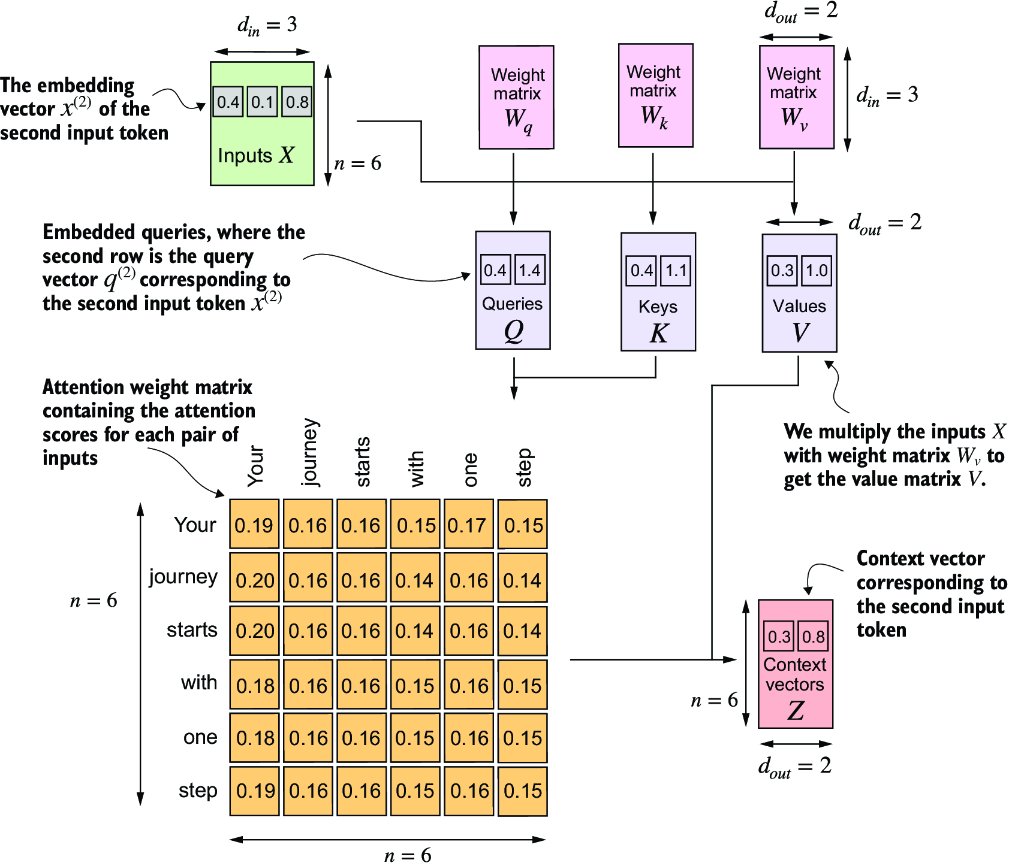

Steps:
1. Input vectors -> Input Matrix X [tiktoken, window slider, Token embedding]
2. Wq, Wk, Wv.  query_x @ [torch.nn.Parameter(torch.rand(dim_in, dim_out), requires_grad=False)] -> Q, K, V
3. attention_score = Q@ K.T <br>
   -> attention_weight = torch.softmax(attention_score / keys.shape[-1] ** 0.5, dim=-1)<br>
   -> context_vector = attention_weight @ V

**A self-attention class using Pytorch linear layers:**

In [82]:
class SelfAttention_v2(nn.Module):
  def __init__(self, d_in, d_out, qkv_bias=False):
    super().__init__()
    self.w_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.w_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.w_value = nn.Linear(d_in, d_out, bias=qkv_bias)

  def forward(self, x):
    keys = self.w_key(x)
    queries = self.w_query(x)
    values = self.w_value(x)
    attention_scores = queries @ keys.T
    attention_weights = torch.softmax(attention_scores / keys.shape[-1] ** 0.5, dim=-1)
    context_vecter = attention_weights @ values
    return context_vecter

# class SelfAttention_v1(nn.Module):
#   def __init__(self, dim_in, dim_out) -> None:
#     super().__init__()
#     self.W_query = nn.Parameter(torch.rand(dim_in, dim_out))
#     self.W_key = nn.Parameter(torch.rand(dim_in, dim_out))
#     self.W_value = nn.Parameter(torch.rand(dim_in, dim_out))

#   def forward(self, query_focus):
#     keys = query_focus @ self.W_key
#     queries = query_focus @ self.W_query
#     values = query_focus @ self.W_value
#     attention_scores = queries @ keys.T
#     attention_weights = torch.softmax(attention_scores / keys.shape[-1] ** 0.5, dim = -1)
#     context_vec = attention_weights @ values
#     return context_vec

In [83]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(dim_in, dim_out)
out_put = sa_v2(inputs)
out_put

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)

> <h3><b>Compare SelfAttention_v1 and v2:</b></h3>
> Note that nn.Linear in SelfAttention_v2 uses a different weight initialization scheme as nn.Parameter(torch.rand(d_in, d_out)) used in SelfAttention_v1, which causes both mechanisms to produce different results. To check that both implementations, SelfAttention_v1 and SelfAttention_v2, are otherwise similar, we can transfer the weight matrices from a SelfAttention_v2 object to a SelfAttention_v1, such that both objects then produce the same results.



In [84]:
'''
our task is to correctly assign the weights from an instance of SelfAttention_v2
to an instance of SelfAttention_v1. To do this, you need to understand the
relationship between the weights in both versions. (Hint: nn.Linear stores the
weight matrix in a transposed form.) After the assignment, you should observe
that both instances produce the same outputs.
'''

def transfer_weights(sa_v2, sa_v1):
    # Transfer the weights from sa_v2 to sa_v1
    with torch.no_grad(): # tell the model this part not for backpropagation
        sa_v1.W_query.copy_(sa_v2.w_query.weight.T)
        sa_v1.W_key.copy_(sa_v2.w_key.weight.T)
        sa_v1.W_value.copy_(sa_v2.w_value.weight.T)
# Initialize both modules
sa_v2 = SelfAttention_v2(dim_in, dim_out)
sa_v1 = SelfAttention_v1(dim_in, dim_out)

# Transfer weights
transfer_weights(sa_v2, sa_v1)

# Test on some input
out1 = sa_v1(inputs)
out2 = sa_v2(inputs)

# Check closeness
print(torch.allclose(out1, out2, atol=1e-6))  # Should print: True

True


> Attention(Q,K,V)=softmax(Q⋅K.T/√dk)⋅V


### 3.5 Hiding future words with <font color='red'>causal attention</font>

> Attention(Q,K,V)=softmax(Q⋅K.T/√dk)⋅V


Causal attention, also known as masked attention, is a specialized form of self-attention. It restricts a model to only consider previous and current inputs in a squence when processing any given token when computing attention scores.

[-> this is in CONTRAST to the standard self-attention mechanism.<-]

**🔰 只考虑之前和现在的内容去生成Attention scores.为什么需要 “只能看前面” 的注意力？**

> ✅ 因为在 语言模型预测下一个词（token） 的任务中，模型的目标是：
根据前面出现的词，来预测当前或下一个词。
所以，如果模型在预测的时候看到了“后面的词”，就等于是作弊了，违反了语言建模的因果逻causality）。

In [85]:
# 标准 attention（双向）：
# token_3 ↔ token_1, token_2, token_3, token_4, token_5 ✅

# 因果 attention（单向）：
# token_3 → token_1, token_2, token_3 ✅
#           ⛔ 不允许看到 token_4, token_5


因果注意力保证了模型只能基于过去的信息进行推理和预测，从而符合语言生成任务的逻辑。



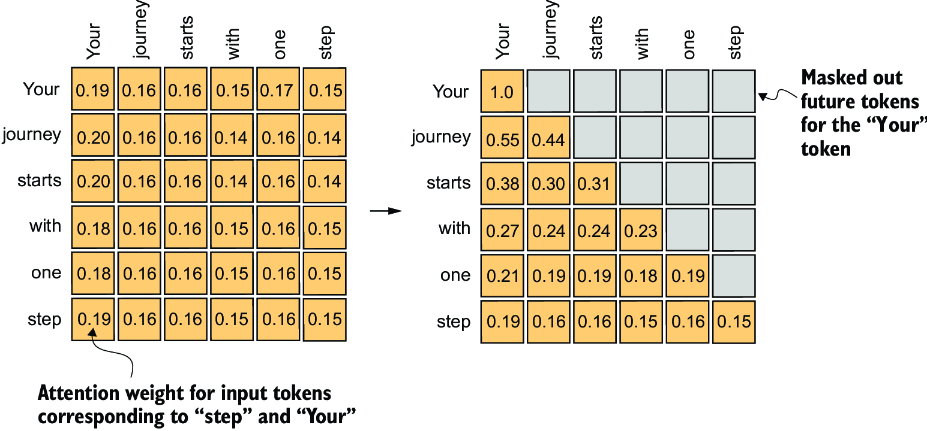

In causal attention, we mask out the attention weights above the diagonal such that for a given input, the LLM can't access future tokens when computing the context vectors using the attention weights.

> "journey" in the second row, we only keep the attention weights for the words before "Your" and in the current position "journey".

####3.5.1 Applying a causal attention mask.

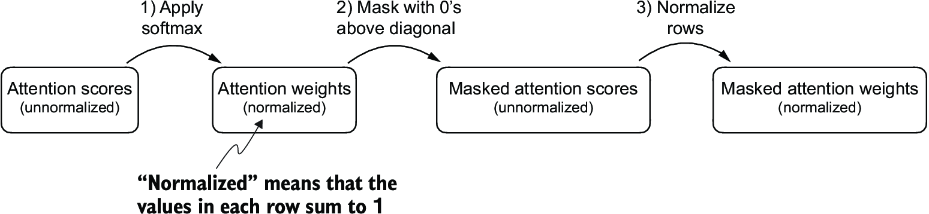

In [86]:
# 1. Attention scores -> softmax -> attention weights
values = sa_v2.w_value(inputs)
keys = sa_v2.w_key(inputs)
queries = sa_v2.w_query(inputs)
attention_scores = queries @ keys.T
attention_weights = torch.softmax(attention_scores / keys.shape[-1] ** 0.5, dim = -1)

# torch.tril
# PyTorch’s tril function to create a mask where the values above the diagonal are zero
mask_weights = torch.tril(attention_weights)
mask_weights

tensor([[0.1766, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1772, 0.1720, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1769, 0.1719, 0.1716, 0.0000, 0.0000, 0.0000],
        [0.1725, 0.1696, 0.1695, 0.1618, 0.0000, 0.0000],
        [0.1687, 0.1694, 0.1692, 0.1637, 0.1634, 0.0000],
        [0.1758, 0.1704, 0.1702, 0.1598, 0.1615, 0.1623]],
       grad_fn=<TrilBackward0>)

In [87]:
# Normalize the mask_weights
'''
Can't use torch.softmax straightly. all value 0.000s will be considered to be signed a value,
but we don't want to. We can signed with -infi to 0s, solution after this part.
'''
row_sum = mask_weights.sum(dim=-1, keepdim=True)
'''
keepdim: Ensure the output have the same dim with input. otherwise, it will be
1 dim.

tensor([[0.1921],
        [0.3700],
        [0.5357],
        [0.6775],
        [0.8415],
        [1.0000]], grad_fn=<SumBackward1>)

vs.

tensor([0.1921, 0.3700, 0.5357, 0.6775, 0.8415, 1.0000],
       grad_fn=<SumBackward1>)
'''
nlm_weight = mask_weights / row_sum
nlm_weight

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5075, 0.4925, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3399, 0.3303, 0.3298, 0.0000, 0.0000, 0.0000],
        [0.2562, 0.2519, 0.2517, 0.2402, 0.0000, 0.0000],
        [0.2021, 0.2030, 0.2028, 0.1962, 0.1959, 0.0000],
        [0.1758, 0.1704, 0.1702, 0.1598, 0.1615, 0.1623]],
       grad_fn=<DivBackward0>)

Information leakage
>after masking and renormalization, the distribution of attention weights is as if it was calculated only among the unmasked positions to begin with. This ensures there’s no information leakage from future (or otherwise masked) tokens as we intended.

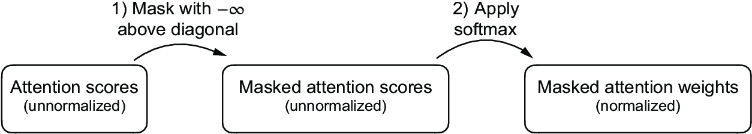

目的是在较小的范围内进行softmax,这样可以避免触及到其他不相干或者说是未来的vectors

In [88]:
'''
-infi solutions: Reduce the overfitting
'''

length, height = attention_scores.shape
masks = torch.triu(torch.ones(length, height), diagonal=1)
# tensor([[0., 1., 1., 1., 1., 1.],
#         [0., 0., 1., 1., 1., 1.],
#         [0., 0., 0., 1., 1., 1.],
#         [0., 0., 0., 0., 1., 1.],
#         [0., 0., 0., 0., 0., 1.],
#         [0., 0., 0., 0., 0., 0.]])
inf_masks = attention_scores.masked_fill(masks.bool(), -torch.inf)
# tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
#         [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
#         [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
#         [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
#         [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
#         [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
#        grad_fn=<MaskedFillBackward0>)
attention_weights = torch.softmax(inf_masks / keys.shape[-1] ** 0.5, dim=-1)

context_v = attention_weights @ values
attention_weights, context_v

(tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5075, 0.4925, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3399, 0.3303, 0.3298, 0.0000, 0.0000, 0.0000],
         [0.2562, 0.2519, 0.2517, 0.2402, 0.0000, 0.0000],
         [0.2021, 0.2030, 0.2028, 0.1962, 0.1959, 0.0000],
         [0.1758, 0.1704, 0.1702, 0.1598, 0.1615, 0.1623]],
        grad_fn=<SoftmaxBackward0>),
 tensor([[ 0.2482, -0.4838],
         [ 0.3715, -0.4308],
         [ 0.4156, -0.4117],
         [ 0.3776, -0.3530],
         [ 0.3981, -0.3243],
         [ 0.3672, -0.3085]], grad_fn=<MmBackward0>))

A more efficient way to obtain the masked attention weight matrix in causal attention is to mask the attention scores with negative infinity values before applying the softmax function

#### 3.5.2 Masking additional attention weights with <font color='red'>DROPOUT</font>



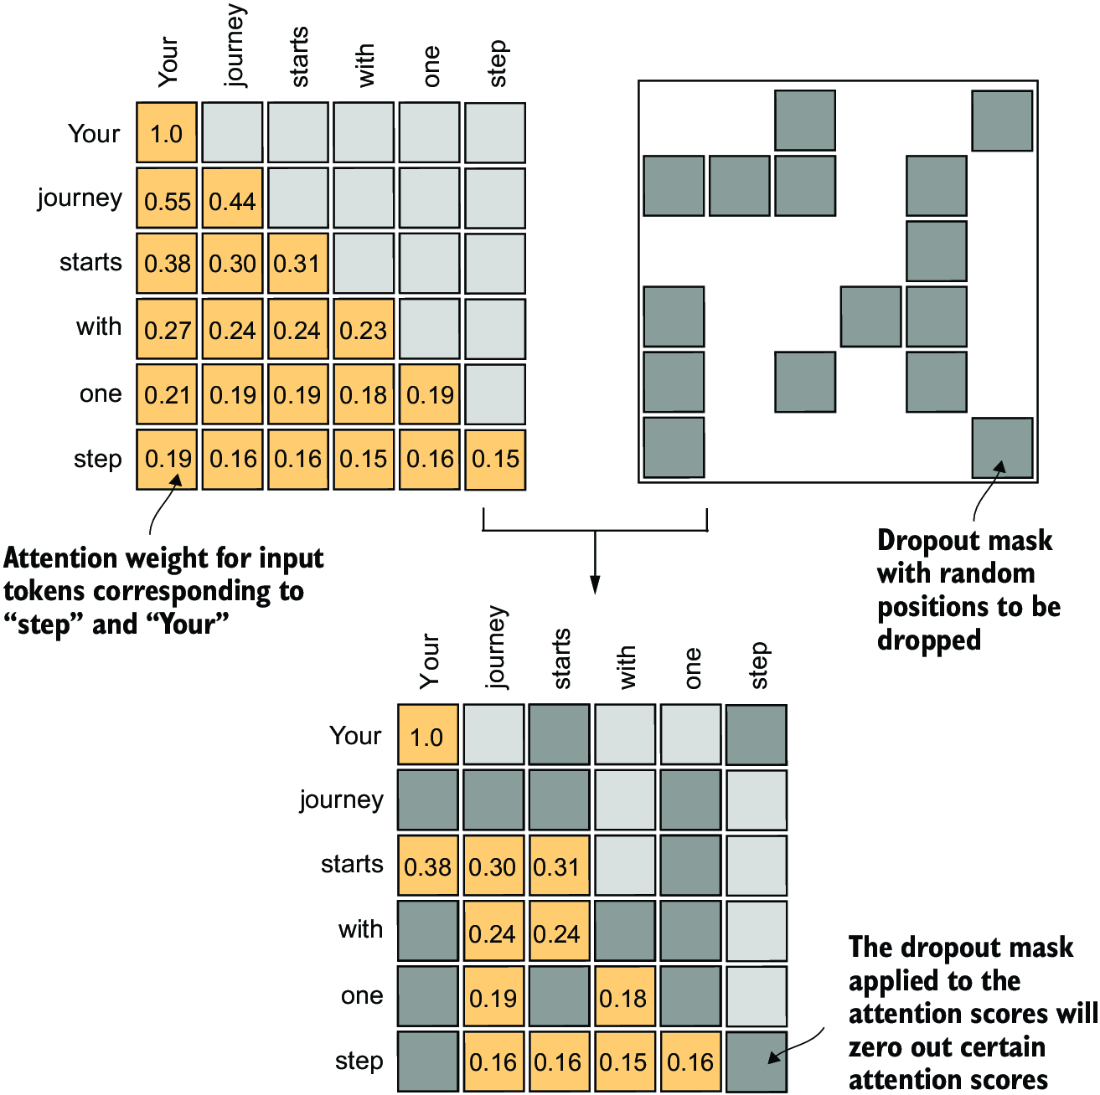

>Dropout in deep learning is a technique where randomly selected hidden layer units are ignored during training. Effectively "dropping" them out. This method helps prevent overfitting by ensuring that a model does NOT become overly reliant on any specific set of hidden layer units.
***
>In the transformer architecture, including models like GPT, dropout in the attention mechanism is typically applied at two specific times: after calculating the attention weights or after applying the attention weights to the value vectors

- 随机剔除掉attention weight可以避免模型变的总是趋向于依赖摸一个或几个特定的layer units.

- 选择时机: 算出attention weights之后 或者 用attention weights 和 value 也就是在计算context vector的时候.

In [89]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) # Dropout rate 50%
weights_dropout = dropout(attention_weights)
weights_dropout

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.9849, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6595, 0.0000, 0.0000, 0.0000],
        [0.5124, 0.5038, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4043, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3408, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)

#### 3.5.3 Implementing a compact <font color='red'>causal attention class</font>

将 causal attention 和 dropout modifications 加入到之前设计的 python class中. 这个Class将会用来搭建Multi-head attention


<font color='red'>Compact Causal Attention Class</font>

In [90]:
import torch.nn as nn

class CausalAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, qkv_bias = False):
    super().__init__()

    self.W_query = nn.Linear(d_in, d_out, bias = qkv_bias) # Note: 尽管parameters是d_in， d_out，但是，W 的 shape 是（d_out，d_in）
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.dropout = nn.Dropout(dropout)

    self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal = 1))

  def forward(self, vector):
    _, num_tokens, d_in = vector.shape
    keys = self.W_key(vector)
    values = self.W_value(vector)
    queries = self.W_query(vector)

    attention_score = queries @ keys.transpose(1, 2)

    attention_score.masked_fill_(
        self.mask.bool()[:num_tokens, :num_tokens], -torch.inf
        # 确保 mask has same size of the vector， otherwise raise a shape mismatch.
    )

    attention_weights = torch.softmax(
        attention_score / keys.shape[-1] ** 0.5, dim=-1
    )

    attention_weights = self.dropout(attention_weights)

    context_vector = attention_weights @ values

    return context_vector

**🔰 W_* 是 2-dim， looks like: (d_in, d_out). 但是vector在这里是3-dim looks like: (_, num_tokens, d_in). 这里是如何工作的？**

> ✅ PyTorch's nn.Linear automatically broadcasts over the leading dimensions。PyTorch 将 （_, num_tokens）看作是一个整体 - batch dimension。
> vector @ W.T = ( _ , num_tokens, d_in) @ (d_out, d_in).T => ( _ , num_tokens, d_out)

In [101]:
# inputs = torch.tensor(
#   [[0.43, 0.15, 0.89], # Your     (x^1)
#    [0.55, 0.87, 0.66], # journey  (x^2)
#    [0.57, 0.85, 0.64], # starts   (x^3)
#    [0.22, 0.58, 0.33], # with     (x^4)
#    [0.77, 0.25, 0.10], # one      (x^5)
#    [0.05, 0.80, 0.55]] # step     (x^6)
# )
# Create batch of size 2
batch = torch.stack((inputs, inputs), dim=0)  # shape = (2, 6, 3)

# Set dimensions
d_in = batch.shape[-1]
d_out = 2

# Create and run model
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, dropout=0.0)
context_vecs = ca(batch)

print("context_vecs.shape:", context_vecs.shape)

context_vecs.shape: torch.Size([2, 6, 2])


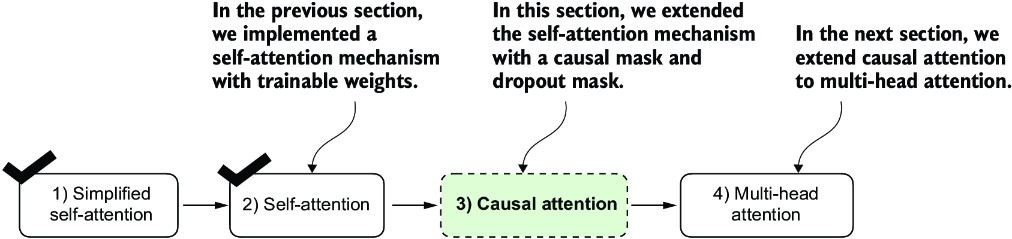

### 3.6 Extending single-head attention to <font color='red'>multi-head attention</font>


Multi-head: Dividing the attention mechanism into multiple heads, each operating independently.

There is only ONE set of attention weights processing the input sequentially.

#### 3.6.1 Stacking multiple single-head attention layers


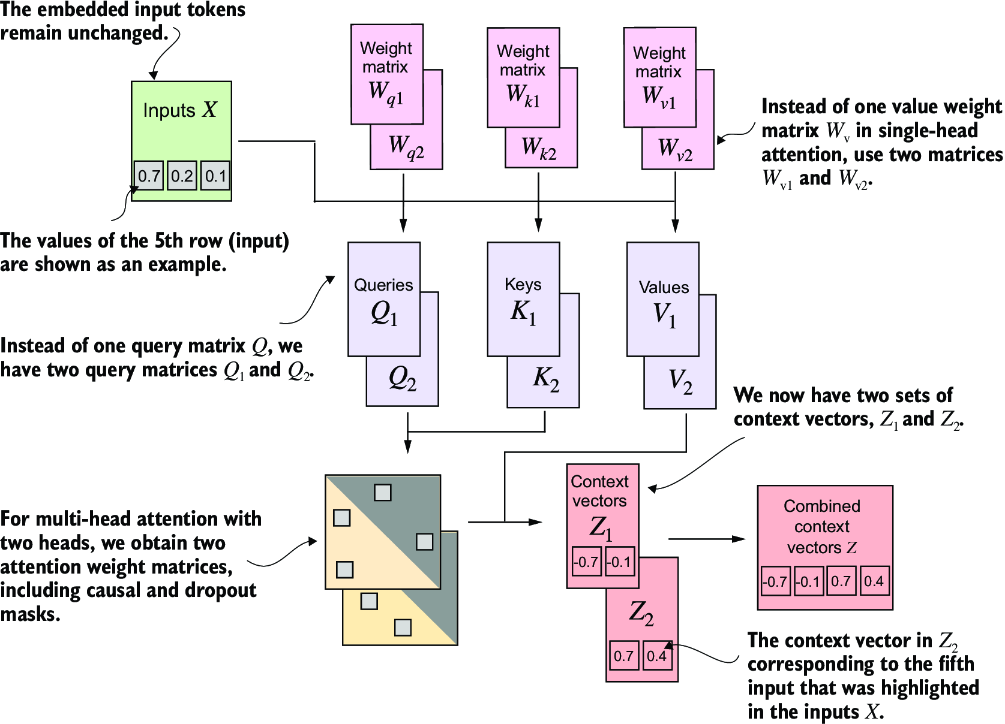

The main idea behind multi-head attention is to run the attention mechanism multiple times (in parallel) with different, learned linear projections—the results of multiplying the input data (like the query, key, and value vectors in attention mechanisms) by a weight matrix.

In [92]:
class MultiHeadAttentionWrapper(nn.Module):
  def __init__(self, d_in, d_out, context_length,
                 dropout, num_heads, qkv_bias=False):
    super().__init__()

    self.heads = nn.ModuleList(
            [CausalAttention(
                  d_in, d_out, context_length, dropout, qkv_bias
              )
              for _ in range(num_heads)]
        )

  def forward(self, x):
      return torch.cat([head(x) for head in self.heads], dim=-1)

- self.heads -> A nn.ModuleList contains a list of CausalAttention, the length depend on the number of heads are needed.

- torch.cat -> merge ModeleList together base on dim requirement. CausalAttention's shape is (a, b, c), when dim=-1, the torch.cat should only consider c.

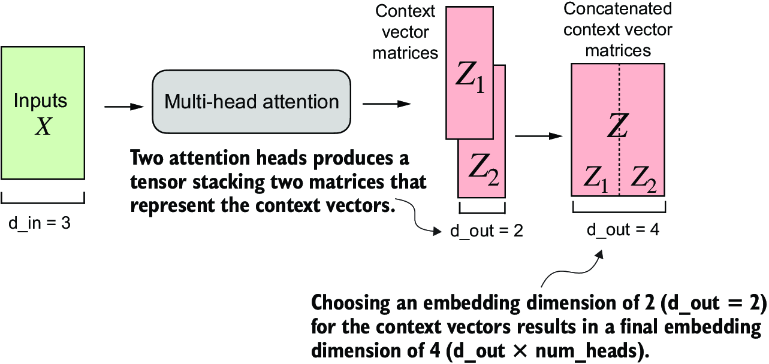

> ♻️ num_heads = 2, d_out = 2

In [93]:
torch.manual_seed(123)
context_length = batch.shape[1]
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(
    d_in, d_out, context_length, 0.0, num_heads=2
)
context_vecs = mha(batch)


batch.shape, mha, context_vecs, context_vecs.shape

(torch.Size([2, 6, 3]),
 MultiHeadAttentionWrapper(
   (heads): ModuleList(
     (0-1): 2 x CausalAttention(
       (W_query): Linear(in_features=3, out_features=2, bias=False)
       (W_key): Linear(in_features=3, out_features=2, bias=False)
       (W_value): Linear(in_features=3, out_features=2, bias=False)
       (dropout): Dropout(p=0.0, inplace=False)
     )
   )
 ),
 tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
          [-0.5874,  0.0058,  0.5891,  0.3257],
          [-0.6300, -0.0632,  0.6202,  0.3860],
          [-0.5675, -0.0843,  0.5478,  0.3589],
          [-0.5526, -0.0981,  0.5321,  0.3428],
          [-0.5299, -0.1081,  0.5077,  0.3493]],
 
         [[-0.4519,  0.2216,  0.4772,  0.1063],
          [-0.5874,  0.0058,  0.5891,  0.3257],
          [-0.6300, -0.0632,  0.6202,  0.3860],
          [-0.5675, -0.0843,  0.5478,  0.3589],
          [-0.5526, -0.0981,  0.5321,  0.3428],
          [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>),
 torch.Size([2, 6, 

The first dimension of the resulting context_vecs tensor is 2 since we have two input texts (the input texts are duplicated, which is why the context vectors are exactly the same for those). The second dimension refers to the 6 tokens in each input. The third dimension refers to the four-dimensional embedding of each token.

The first dim  也就是 0 位， 是2， 因为我们的input的数量是2个，【【1-matrix】， 【1-matrix】】。

1 位，第二维度的 6， 是说有 6 个tokens 在每一个 1-matrix

最后在 2 位，第三维度是 4， 因为每一个out 是2， 我们一共有两个input，所以是4。 和图示描述一致。

🔰 Exercise 3.2 Returning two-dimensional embedding vectors
> ✅ d_out = 1

#### 3.6.2 Implementing multi-head attention with weight splits

> An Efficient Multi-head Attention Class.

In [103]:
class MultiHeadAttention(nn.Module):
  '''
  #1 Reduces the projection dim to match the desired output dim
  #2 Uses a Linear layer to combine head outputs
  #3 Tensor shape: (b, num_tokens, d_out)
  #4 We implicitly split the matrix by adding a num_heads dimension. Then we unroll the last dim: (b, num_tokens, d_out) -&gt; (b, num_tokens, num_heads, head_dim).
  #5 Transposes from shape (b, num_tokens, num_heads, head_dim) to (b, num_heads, num_tokens, head_dim)
  #6 Computes dot product for each head
  #7 Masks truncated to the number of tokens
  #8 Uses the mask to fill attention scores
  #9 Tensor shape: (b, num_tokens, n_heads, head_dim)
  #10 Combines heads, where self.d_out = self.num_heads * self.head_dim
  #11 Adds an optional linear projection
  '''
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()

    assert(d_out % num_heads == 0), "d_out must be divisible by num_heads"

    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out #1
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.out_proj = nn.Linear(d_out, d_out) #2
    self.dropout = nn.Dropout(dropout)
    self.register_buffer(
        "mask",
        torch.triu(torch.ones(context_length, context_length),
                    diagonal=1)
    )

  def forward(self, x):
      b, num_tokens, d_in = x.shape
      keys = self.W_key(x)         #3
      queries = self.W_query(x)    #3
      values = self.W_value(x)     #3

      keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)       #4
      values = values.view(b, num_tokens, self.num_heads, self.head_dim)
      queries = queries.view(
          b, num_tokens, self.num_heads, self.head_dim
      )

      keys = keys.transpose(1, 2)          #5
      queries = queries.transpose(1, 2)    #5
      values = values.transpose(1, 2)      #5

      attn_scores = queries @ keys.transpose(2, 3)   #6
      mask_bool = self.mask.bool()[:num_tokens, :num_tokens]    #7

      attn_scores.masked_fill_(mask_bool, -torch.inf)     #8

      attn_weights = torch.softmax(
          attn_scores / keys.shape[-1]**0.5, dim=-1)
      attn_weights = self.dropout(attn_weights)

      context_vec = (attn_weights @ values).transpose(1, 2)   #9
#10
      context_vec = context_vec.contiguous().view(
          b, num_tokens, self.d_out
      )
      context_vec = self.out_proj(context_vec)    #11
      return context_vec



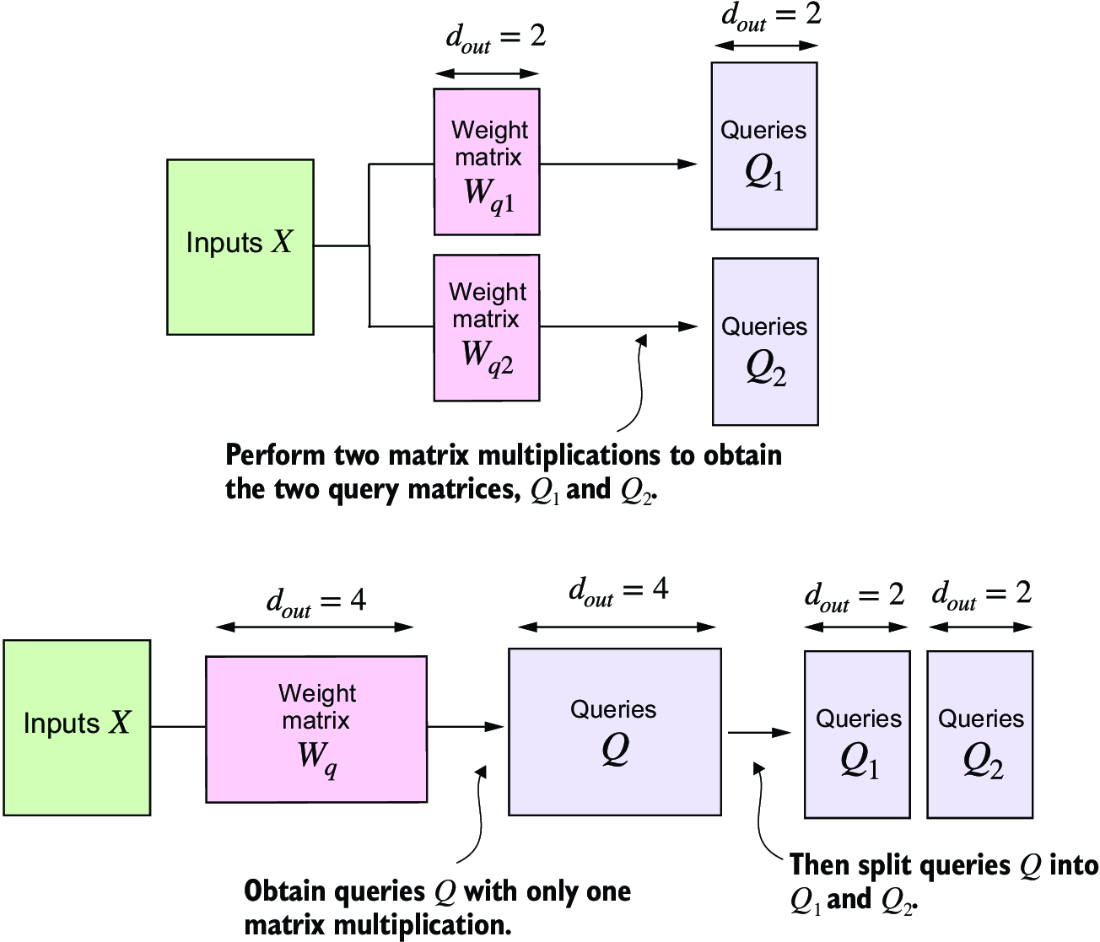

> In the MultiHeadAttentionWrapper class with two attention heads, we initialized two weight matrices, Wq1 and Wq2, and computed two query matrices, Q1 and Q2 (top). In the MultiheadAttention class, we initialize one larger weight matrix Wq, only perform one matrix multiplication with the inputs to obtain a query matrix Q, and then split the query matrix into Q1 and Q2 (bottom). We do the same for the keys and values, which are not shown to reduce visual clutter.


The splitting of the query, key, and value tensors is achieved through tensor reshaping and transposing operations using PyTorch’s .view and .transpose methods. The input is first transformed (via linear layers for queries, keys, and values) and then reshaped to represent multiple heads.

The key operation is to split the d_out dimension into num_heads and head_dim, where head_dim = d_out / num_heads. This splitting is then achieved using the .view method: a tensor of dimensions (b, num_tokens, d_out) is reshaped to dimension (b, num_tokens, num_heads, head_dim).

The tensors are then transposed to bring the num_heads dimension before the num_ tokens dimension, resulting in a shape of (b, num_heads, num_tokens, head_dim). This transposition is crucial for correctly aligning the queries, keys, and values across the different heads and performing batched matrix multiplications efficiently.

♻️ 以上这部分很绕，尤其是在不同维度之间的转换。需要更大量的学习。 我觉得以下多维度matrix之间的转换是个难点。需要熟练掌握。

假如我们有 tensor =

In [95]:
#1 The shape of this tensor is (b, num_heads, num_tokens, head_dim) = (1, 2, 3, 4).

a = torch.tensor([[[[0.2745, 0.6584, 0.2775, 0.8573],    #1
                    [0.8993, 0.0390, 0.9268, 0.7388],
                    [0.7179, 0.7058, 0.9156, 0.4340]],

                   [[0.0772, 0.3565, 0.1479, 0.5331],
                    [0.4066, 0.2318, 0.4545, 0.9737],
                    [0.4606, 0.5159, 0.4220, 0.5786]]]])

In [96]:
print(a @ a.transpose(2, 3))


tensor([[[[1.3208, 1.1631, 1.2879],
          [1.1631, 2.2150, 1.8424],
          [1.2879, 1.8424, 2.0402]],

         [[0.4391, 0.7003, 0.5903],
          [0.7003, 1.3737, 1.0620],
          [0.5903, 1.0620, 0.9912]]]])


In this case, the matrix multiplication implementation in PyTorch handles the four-dimensional input tensor so that the matrix multiplication is carried out between the <font color='red'>two last dimensions (num_tokens, head_dim) and then repeated for the individual heads.</font>

In [97]:
first_head = a[0, 0, :, :]
first_res = first_head @ first_head.T
print("First head:\n", first_res)

second_head = a[0, 1, :, :]
second_res = second_head @ second_head.T
print("\nSecond head:\n", second_res)

First head:
 tensor([[1.3208, 1.1631, 1.2879],
        [1.1631, 2.2150, 1.8424],
        [1.2879, 1.8424, 2.0402]])

Second head:
 tensor([[0.4391, 0.7003, 0.5903],
        [0.7003, 1.3737, 1.0620],
        [0.5903, 1.0620, 0.9912]])


继续使用 MultiHeadAttention，在计算注意力权重和上下文向量后，所有 head 的上下文向量会被转置回形状 (b, num_tokens, num_heads, head_dim)。然后，这些向量会被重塑（扁平化）为形状 (b, num_tokens, d_out)，从而有效地合并所有 head 的输出。

此外，在合并 head 之后，我们为 MultiHeadAttention 添加了一个输出投影层 (self.out_proj)，而 CausalAttention 类中并没有这个层。这个输出投影层并非必需（更多详情请参阅附录 B），但它在许多 LLM 架构中被广泛使用，因此我为了完整性而在这里添加了它。

尽管 MultiHeadAttention 类由于额外的张量重塑和转置而看起来比 MultiHeadAttentionWrapper 更复杂，但它的效率更高。原因是我们只需要一次矩阵乘法来计算key，例如，keys = self.W_key(x)（查询和值也是如此）。在 MultiHeadAttentionWrapper 中，我们需要对每个注意力头重复进行这个矩阵乘法，这在计算上是最昂贵的步骤之一。

In [104]:
torch.manual_seed(123)
batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

RuntimeError: shape '[2, 6, 2, 2]' is invalid for input of size 24